<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales-con-R/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas

Fecha: 

In [3]:
install.packages("deSolve")
library(deSolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Descripción del proceso (en este caso, las reacciones): 
El sistema bioquímico de formación y degradación de la GFP a considerar en está dado por las reacciones representadas por:

$$
\varnothing \xrightarrow[]{k_1} \text{GFP} \xrightarrow[]{k_2}  \varnothing \tag{1}
$$

# 1. Establecer modelo y obtener estado estacionario 

## Red para describir las reacciones en las que participa la GFP

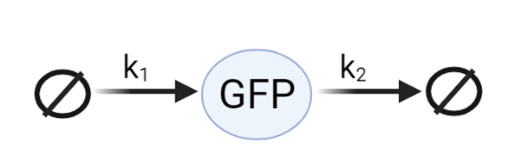

## Modelo matemático 

Realizando el balance de materia para la proteína GFP se tiene

$$
\text{cambio de concentración de la GFP} = \text{entrada de GFP} - \text{degradación de GFP} \tag{2}
$$

$$
\frac{dGFP}{dt} = k_1 s - k_2 GFP \tag{3} 
$$

En (3) se supone que la producción de GFP se realiza a una velocidad constante. Por otro lado, la degradación de la GFP se establece proporcional a su concentración.

Dado que el primer término en (3) es una constante se puede escribir como 

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP \tag{4}
$$

donde $p_1 = k_1 s$

## Análisis de estabilidad 

Igualando (4) a cero y despejando de obtiene el estado estacionario.

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP = 0 \rightarrow GFP_{ss} = \frac{p_1}{k_2}
$$

In [4]:
# calcular estado estacionario 
steady_state <- function(p) {
    with(as.list(p), {
        GFPss <- p1/k2

        return(GFPss)
    })
}

In [5]:
# establecer parámetros 
p <- c(p1 = 1, k2 = 1)

# calcular estado estable
GFPss <- steady_state(p)
print(GFPss)

[1] 1


# Algoritmo de Gillespie 

Primero es necesario establecer una función que nos permita calcular las velocidades de reacción en cada instante 


In [7]:
get_rates = function(GFP, rate_const) {

    f = c(rate_const[1], rate_const[2]*GFP)

    return(f)
}

In [14]:
gillespieGFp = function(GFP0, rate_const, get_rates, tend) {

    tvec = vector("numeric") # vector para guardar los tiempos en los que ocurren las rxs

    GFPvec = vector("numeric") # vector para guardar los valores de GFP en el tiempo

    tvec[1] = 0 # tiempo inicial 

    GFPvec[1] = GFP0 # GFP inicial 

    while (tvec[length(tvec)] < tend) { # mientras el último valor de tiempo sea menor a tend
        current_GFP = GFPvec[length(GFPvec)] # valor actual de GFP
        rates = get_rates(current_GFP, rate_const) # calcular velocidades de reacción
        rate_sum = sum(rates)

        tau = rexp(1, rate_sum) # tomar el paso de tiempo de una función de distribución exponencial 

        tvec = c(tvec, tvec[length(tvec)] + tau) # nuevo tiempo en el que ocurre la rx

        rx = sample(length(rates), 1, prob = rates) # seleccionar la rxs que ocurrirá con una probabilidad 
        # propoorcional a su velocidad 

        # actualizar valor de GFP
        if (rx == 1) {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] + 1) # producción
        }
        else {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] - 1) # degradación
        }
    }
    return(list(t = tvec, GFP = GFPvec))

}

In [19]:
# parámetros 
GFP0 = 0 # initial conditions
c1 = 2
c2 = 0.1
tend = 100 # tiempo final 
rate_const = c(c1,c2) # parameters (rate constants)

In [40]:
# correr algoritmo
out = gillespieGFp(GFP0, rate_const, get_rates, tend)

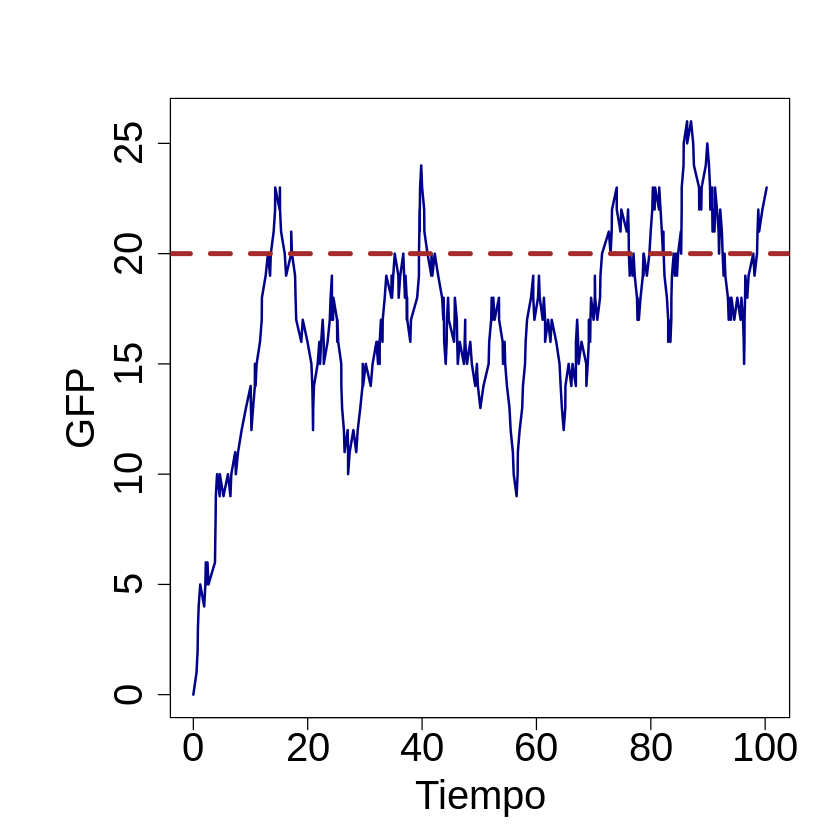

In [41]:
par(mar = c(5,7,4,2) + 0.1)
plot(out$t, out$GFP, type = "l", cex.axis = 2, cex.lab = 2, col = "darkblue", lwd = 2, xlab = "Tiempo", ylab = "GFP")
abline(h = 20, lty = 2, col = "brown", lwd = 4)

# Obtener la concentración final de GFP al realizar varias simulaciones para determinar su distribución 

In [46]:
# función para calcular el valor final de GFP
GFP_end <- function(GFP0, rate_const, get_rates, tend) {
        
        out = gillespieGFp(GFP0, rate_const, get_rates, tend)
        
        n <- length(out$GFP)
        
        GFP = out$GFP[n]
        
        return(GFP)
}

In [47]:
GFP_end(GFP0, rate_const, get_rates, tend)

[1] 27

In [48]:
GFP_ends <- replicate(100, {
        
        GFPs = GFP_end(GFP0, rate_const, get_rates, tend)
})

Warning message in plot.window(xlim, ylim, "", ...):
“"cex.axi" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"cex.axi" is not a graphical parameter”
Warning message in axis(1, ...):
“"cex.axi" is not a graphical parameter”
Warning message in axis(2, ...):
“"cex.axi" is not a graphical parameter”


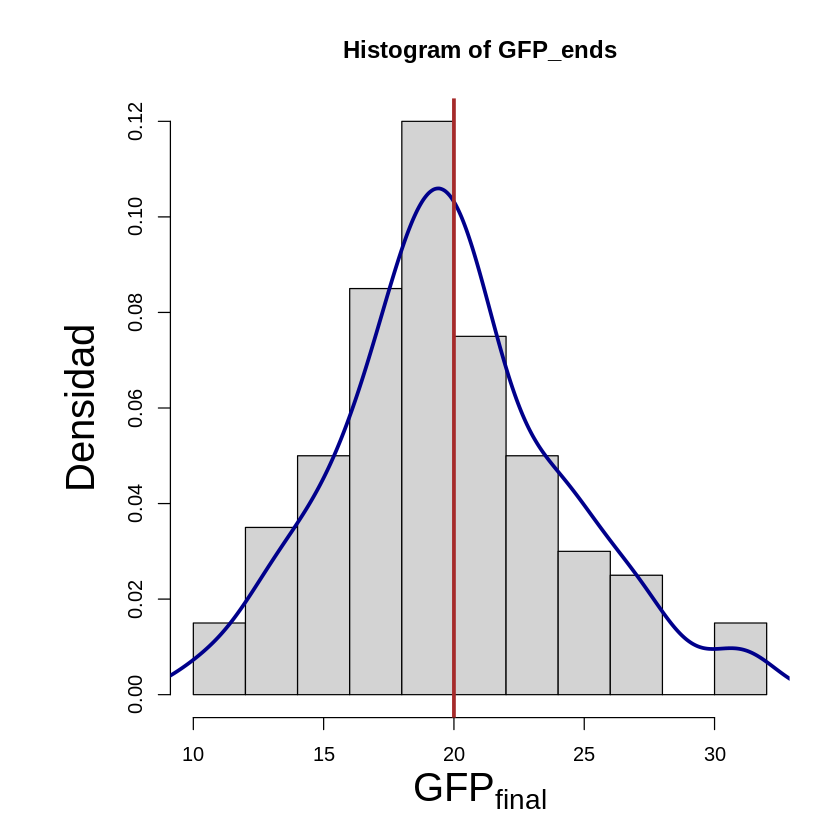

In [58]:
# mostrar distribución
par(mar = c(5,7,4,2) + 0.1)
hist(GFP_ends,prob = TRUE, xlab = expression(GFP[final]), ylab = "Densidad", cex.lab = 2, cex.axi = 2)
lines(density(GFP_ends), col="darkblue", lwd = 3)
abline(v=c1/c2, col="brown", lwd = 3)

# Simular con modelo determinista

In [50]:
# modelo en ED
detGFP <- function(t, state, parms) {
        
        with(as.list(c(state, parms)), {
                
                dGFP <- c1-c2*GFP
                
                return(list(c(dGFP)))
        })
        
}

In [51]:
# tiempo de integración
times <- seq(0,100,1)
# condiciones iniciales 
s <- c(GFP = GFP0)
# parámetros
parms <- c(c1 = c1, c2 = c2)

In [52]:
# simular mdelo 
outD <- ode(y = s, times = times, func = detGFP, parms = parms)

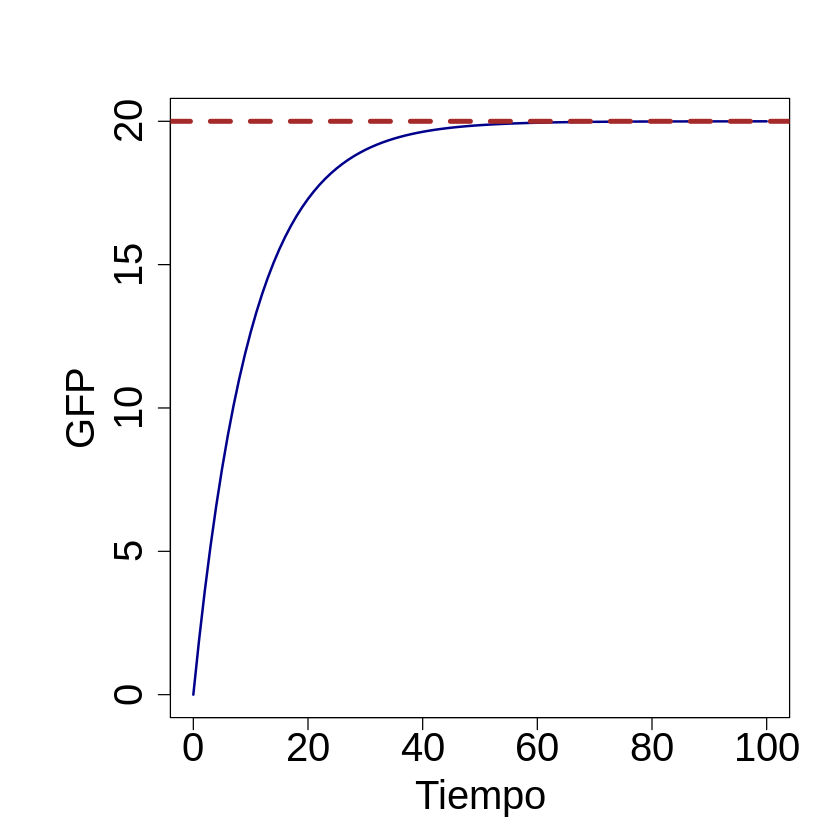

In [61]:
# mostrar resultados 
par(mar = c(5,7,4,2) + 0.1)
plot(outD,type = "l", cex.axis = 2, cex.lab = 2, col = "darkblue", lwd = 2, xlab = "Tiempo", ylab = "GFP", main = "")
abline(h = 20, lty = 2, col = "brown", lwd = 4)